# Abstract

Powered by Dark Sky (https://darksky.net/poweredby/)

# Imports

In [1]:
# imports

# misc
import datetime
import math
import os, sys, shutil
from collections import defaultdict
from tqdm import tqdm

# basics
import numpy as np
from numpy import loadtxt
import pandas as pd
from pandas.plotting import autocorrelation_plot

# from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error



# keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# charting
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline 


# for darksky api
import json
from pandas.io.json import json_normalize
import requests






Using TensorFlow backend.


# Code needed to load dataset from driven data

In [2]:
# load the data
df_train = pd.read_csv('source_data/dengue_features_train.csv') 

In [3]:
df_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [4]:
df_train.tail()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0
1455,iq,2010,25,2010-06-25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,...,36.90,89.082857,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4


In [5]:
train_labels = pd.read_csv('source_data/dengue_labels_train.csv')

In [6]:
train_labels.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [7]:
train_labels['year'].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])

In [8]:
df_train.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

# this cell seems to make week_start_date of the sj records a true datetime object, but not the iq records????

In [10]:
# make week_start_date a datetime object
# for index, row in enumerate(df_train):
#     df_train.loc[index, 'week_start_date'] = pd.to_datetime(df_train.loc[index, 'week_start_date'])

In [11]:
# try making a new column instead
df_train['week_start_temp'] = pd.to_datetime(df_train['week_start_date'])

In [12]:
df_train['week_start_temp'].head()

0   1990-04-30
1   1990-05-07
2   1990-05-14
3   1990-05-21
4   1990-05-28
Name: week_start_temp, dtype: datetime64[ns]

In [13]:
df_train['week_start_temp'].tail()

1451   2010-05-28
1452   2010-06-04
1453   2010-06-11
1454   2010-06-18
1455   2010-06-25
Name: week_start_temp, dtype: datetime64[ns]

In [14]:
# drop old week_start_date
df_train = df_train.drop('week_start_date', axis = 1)

In [15]:
# rename week_start_temp
df_train.rename(columns={'week_start_temp': 'week_start_date'}, inplace=True)


In [16]:
# rearrange the columns
cols = df_train.columns.to_list()
cols = cols[-1:] + cols[:-1]


In [17]:
df_train = df_train[cols]


In [18]:
df_train.head()

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1990-04-30,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,1990-05-07,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,1990-05-14,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,1990-05-21,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,1990-05-28,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [19]:
df_train.tail()

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
1451,2010-05-28,iq,2010,21,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,2010-06-04,iq,2010,22,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,2010-06-11,iq,2010,23,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,2010-06-18,iq,2010,24,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0
1455,2010-06-25,iq,2010,25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,...,36.90,89.082857,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4


In [20]:
# df_sj = df_train[df_train['city'] == 'sj']  #this creates a slice of the dataframe, not a new dataframe
# df_iq = df_train[df_train['city'] == 'iq']  #this creates a slice of the dataframe, not a new dataframe

In [21]:
# make seperate training dataframes for each city
df_sj = df_train.copy()
df_iq = df_train.copy()

In [22]:
df_sj.drop(df_sj[df_sj['city'] != 'sj'].index, inplace=True)
df_iq.drop(df_iq[df_iq['city'] != 'iq'].index, inplace=True)


In [23]:
# make seperate training labels dateframes for each city
sj_train_labels = train_labels.copy()
iq_train_labels = train_labels.copy()

sj_train_labels.drop(sj_train_labels[sj_train_labels['city'] != 'sj'].index, inplace=True)
iq_train_labels.drop(iq_train_labels[iq_train_labels['city'] != 'iq'].index, inplace=True)

In [24]:

sj_train_labels = sj_train_labels.drop('city', axis = 1)
iq_train_labels = iq_train_labels.drop('city', axis = 1)

In [25]:
sj_train_labels.tail()

,year,weekofyear,total_cases
931,2008,13,4
932,2008,14,3
933,2008,15,1
934,2008,16,3
935,2008,17,5


In [26]:
iq_train_labels.head()

,year,weekofyear,total_cases
936,2000,26,0
937,2000,27,0
938,2000,28,0
939,2000,29,0
940,2000,30,0


In [27]:
df_sj.tail()

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
931,2008-03-25,sj,2008,13,0.07785,-0.039900,0.310471,0.296243,27.19,296.958571,...,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8
932,2008-04-01,sj,2008,14,-0.03800,-0.016833,0.119371,0.066386,3.82,298.081429,...,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5
933,2008-04-08,sj,2008,15,-0.15520,-0.052750,0.137757,0.141214,16.96,297.460000,...,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7
934,2008-04-15,sj,2008,16,0.00180,NaN,0.203900,0.209843,0.00,297.630000,...,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2
935,2008-04-22,sj,2008,17,-0.03700,-0.010367,0.077314,0.090586,0.00,298.672857,...,2.17,76.960000,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3


In [28]:
df_iq.head()

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
936,2000-07-01,iq,2000,26,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0
937,2000-07-08,iq,2000,27,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6
938,2000-07-15,iq,2000,28,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1
939,2000-07-22,iq,2000,29,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0
940,2000-07-29,iq,2000,30,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0


In [29]:
print("sj length: {}".format(len(df_sj)))
print("iq length: {}".format(len(df_iq)))

sj length: 936
iq length: 520


In [30]:
# https://www.pythonprogramming.in/get-the-day-of-week-from-given-a-date-in-python.html
# Python's program to get the day of week of today or given date.
 
dayofweek = datetime.date(2010, 6, 16).strftime("%A")
print(dayofweek)
# weekday Monday is 0 and Sunday is 6
print("weekday():", datetime.date(2010, 6, 16).weekday())
 
# isoweekday() Monday is 1 and Sunday is 7
print("isoweekday()", datetime.date(2010, 6, 16).isoweekday())
 
dayofweek = datetime.datetime.today().strftime("%A")
print(dayofweek)
print("weekday():", datetime.datetime.today().weekday())
print("isoweekday()", datetime.datetime.today().isoweekday())

Wednesday
weekday(): 2
isoweekday() 3
Friday
weekday(): 4
isoweekday() 5


In [31]:
dayofweek

'Friday'

In [32]:
df_sj['week_start_date'].head(10)

0   1990-04-30
1   1990-05-07
2   1990-05-14
3   1990-05-21
4   1990-05-28
5   1990-06-04
6   1990-06-11
7   1990-06-18
8   1990-06-25
9   1990-07-02
Name: week_start_date, dtype: datetime64[ns]

In [33]:
df_sj.tail(10)

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
926,2008-02-19,sj,2008,8,-0.13865,-0.095067,0.246057,0.228129,0.00,297.907143,...,8.30,74.785714,0.00,14.538571,1.885714,24.900000,5.785714,28.3,21.7,13.3
927,2008-02-26,sj,2008,9,NaN,0.015420,0.211629,0.117343,0.00,297.765714,...,6.46,72.660000,0.00,13.967143,2.285714,24.742857,5.500000,27.8,21.1,12.9
928,2008-03-04,sj,2008,10,-0.08890,-0.090033,0.223243,0.154186,0.00,297.878571,...,6.50,74.681429,0.00,14.474286,2.614286,25.114286,6.114286,29.4,21.1,13.0
929,2008-03-11,sj,2008,11,-0.32140,-0.141200,0.110643,0.141014,0.00,297.595714,...,9.38,71.934286,0.00,13.721429,2.085714,25.328571,5.814286,28.9,22.2,4.4
930,2008-03-18,sj,2008,12,0.04490,0.024450,0.101629,0.088000,0.00,297.404286,...,0.90,72.915714,0.00,13.737143,3.871429,25.200000,7.042857,30.0,20.6,0.5
931,2008-03-25,sj,2008,13,0.07785,-0.039900,0.310471,0.296243,27.19,296.958571,...,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8
932,2008-04-01,sj,2008,14,-0.03800,-0.016833,0.119371,0.066386,3.82,298.081429,...,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5
933,2008-04-08,sj,2008,15,-0.15520,-0.052750,0.137757,0.141214,16.96,297.460000,...,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7
934,2008-04-15,sj,2008,16,0.00180,NaN,0.203900,0.209843,0.00,297.630000,...,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2
935,2008-04-22,sj,2008,17,-0.03700,-0.010367,0.077314,0.090586,0.00,298.672857,...,2.17,76.960000,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3


In [34]:
df_iq.head(10)

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
936,2000-07-01,iq,2000,26,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0
937,2000-07-08,iq,2000,27,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6
938,2000-07-15,iq,2000,28,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1
939,2000-07-22,iq,2000,29,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0
940,2000-07-29,iq,2000,30,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0
941,2000-08-05,iq,2000,31,0.205529,0.190757,0.231671,0.255314,16.24,297.191429,...,1.00,74.728571,16.24,13.421429,13.771429,25.340000,10.940000,32.0,17.0,11.5
942,2000-08-12,iq,2000,32,0.312486,0.329986,0.380586,0.387271,89.37,297.320000,...,26.68,83.275714,89.37,15.311429,11.471429,27.016667,11.650000,34.0,19.9,72.9
943,2000-08-19,iq,2000,33,0.384133,0.392240,0.341780,0.382750,42.08,297.627143,...,16.90,82.490000,42.08,15.465714,13.700000,26.583333,10.316667,33.0,20.5,50.1
944,2000-08-26,iq,2000,34,0.408157,0.322157,0.406714,0.302714,49.22,298.238571,...,5.59,74.740000,49.22,14.444286,13.771429,26.900000,13.400000,34.0,19.0,89.2
945,2000-09-02,iq,2000,35,0.332043,0.321057,0.314614,0.324257,53.65,299.218571,...,16.07,74.151429,53.65,15.057143,12.457143,27.116667,12.266667,34.0,20.0,78.0


In [35]:
df_iq.tail(10)

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
1446,2010-04-23,iq,2010,16,0.231486,0.294686,0.331657,0.244400,86.70,298.438571,...,81.40,95.995714,86.70,19.448571,7.757143,27.850000,9.600000,33.5,22.5,51.1
1447,2010-04-30,iq,2010,17,0.239743,0.259271,0.307786,0.307943,26.00,299.048571,...,23.60,87.657143,26.00,18.068571,8.257143,28.850000,12.125000,36.2,21.4,35.4
1448,2010-05-07,iq,2010,18,0.260814,0.255786,0.257771,0.340286,73.97,297.617143,...,85.46,96.712857,73.97,18.602857,5.714286,27.600000,9.600000,33.2,21.4,8.1
1449,2010-05-14,iq,2010,19,0.168686,0.158500,0.133071,0.145600,59.40,297.278571,...,87.30,97.445714,59.40,18.391429,6.185714,27.400000,10.400000,33.7,21.2,32.0
1450,2010-05-21,iq,2010,20,0.263071,0.272500,0.258271,0.244500,1.15,297.648571,...,8.80,78.998571,1.15,14.908571,11.242857,25.633333,9.200000,34.0,20.0,2.5
1451,2010-05-28,iq,2010,21,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,2010-06-04,iq,2010,22,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,2010-06-11,iq,2010,23,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,2010-06-18,iq,2010,24,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0
1455,2010-06-25,iq,2010,25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,...,36.90,89.082857,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4


In [36]:
sj_start_week = df_sj['weekofyear'][df_sj['year'] == 1990]
sj_end_week = df_sj['weekofyear'][df_sj['year'] == 2008]

iq_start_week = df_iq['weekofyear'][df_iq['year'] == 2000]
iq_end_week = df_iq['weekofyear'][df_iq['year'] == 2010]

In [37]:
iq_start_week.describe()

count    26.000000
mean     38.500000
std       7.648529
min      26.000000
25%      32.250000
50%      38.500000
75%      44.750000
max      51.000000
Name: weekofyear, dtype: float64

In [38]:
print('sj min: {}'.format(sj_start_week.min()))
print('sj max: {}'.format(sj_end_week.max()))

print('iq min: {}'.format(iq_start_week.min()))
print('iq max: {}'.format(iq_start_week.max()))

sj min: 18
sj max: 17
iq min: 26
iq max: 51


In [39]:
# sj starts in week 18 of 1990 and ends week 17 of 2008
# iq starts in week 26 of 2000 and ends week 51 of 2010

# estimates of the number of api calls to darksky:
# sj = 35 weeks in 1990 + 52 weeks 1991 - 2008 + 17 weeks in 2008 = 988 weeks x 7 days = 6,916
# iq = 27 weeks in 2000 + 52 weeks 2001 - 2009 + 51 weeks in 2010 = 546 weeks x 7 days = 3,822
# total = 10,738 whcih means 11 days of 1K/day

In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
week_start_date                          1456 non-null datetime64[ns]
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysi

In [41]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 4 columns):
city           1456 non-null object
year           1456 non-null int64
weekofyear     1456 non-null int64
total_cases    1456 non-null int64
dtypes: int64(3), object(1)
memory usage: 45.6+ KB


In [42]:
df_train['total_cases'] = train_labels['total_cases']

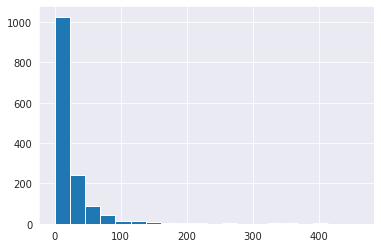

In [48]:
df_train['total_cases'].hist(bins=20)

In [49]:
df_train.iloc[:,4:12].describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k
count,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000
mean,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356
std,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810
min,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857
25%,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929
50%,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714
75%,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000
max,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000


In [50]:
df_train.iloc[:,12:18].describe()

,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg
count,1446.000000,1446.000000,1446.000000,1446.000000,1443.000000,1446.000000
mean,303.427109,295.719156,40.151819,82.161959,45.760388,16.746427
std,3.234601,2.565364,43.434399,7.153897,43.715537,1.542494
min,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714
25%,301.000000,293.900000,13.055000,77.177143,9.800000,15.557143
50%,302.400000,296.200000,27.245000,80.301429,38.340000,17.087143
75%,305.500000,297.900000,52.200000,86.357857,70.235000,17.978214
max,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429


In [51]:
df_train.iloc[:,18:24].describe()

,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000
mean,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360
std,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314
min,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000
50%,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000
75%,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000
max,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


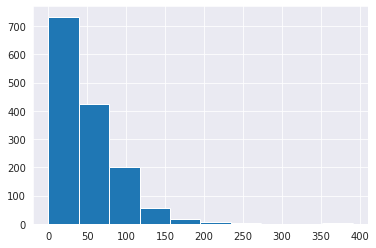

In [52]:
df_train.precipitation_amt_mm.hist()

In [53]:
df_train.isnull().sum()

week_start_date                            0
city                                       0
year                                       0
weekofyear                                 0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [54]:
# function to fill all missing values with the mean for each factor

def fill_mean(dataframe):
    for i, col in enumerate(dataframe):
        if col != 'date':
            dataframe[col].fillna(dataframe[col].mean(), inplace=True)
    

In [55]:
train_labels.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


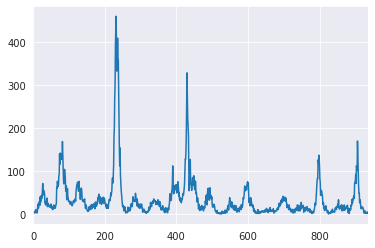

In [56]:
# now look at the driven data dataset
sj_cases = train_labels[train_labels['city'] == 'sj']
iq_cases = train_labels[train_labels['city'] == 'iq']



sj_cases['total_cases'].plot()
# iq_cases['total_cases'].plot()


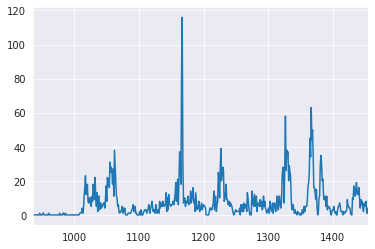

In [57]:
iq_cases['total_cases'].plot()

In [58]:
df_sj.groupby(by = 'year').head(20)

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1990-04-30,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,1990-05-07,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,1990-05-14,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,1990-05-21,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,1990-05-28,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,2008-03-25,sj,2008,13,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,...,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8
932,2008-04-01,sj,2008,14,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,...,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5
933,2008-04-08,sj,2008,15,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,...,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7
934,2008-04-15,sj,2008,16,0.001800,NaN,0.203900,0.209843,0.00,297.630000,...,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2


In [59]:
df_iq.groupby(by = 'year').head(20)

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
936,2000-07-01,iq,2000,26,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0
937,2000-07-08,iq,2000,27,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6
938,2000-07-15,iq,2000,28,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1
939,2000-07-22,iq,2000,29,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0
940,2000-07-29,iq,2000,30,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,2010-04-16,iq,2010,15,0.157686,0.156614,0.184014,0.135886,17.33,298.305714,...,150.80,93.655714,17.33,18.677143,7.228571,27.150000,9.600000,33.0,21.2,18.0
1446,2010-04-23,iq,2010,16,0.231486,0.294686,0.331657,0.244400,86.70,298.438571,...,81.40,95.995714,86.70,19.448571,7.757143,27.850000,9.600000,33.5,22.5,51.1
1447,2010-04-30,iq,2010,17,0.239743,0.259271,0.307786,0.307943,26.00,299.048571,...,23.60,87.657143,26.00,18.068571,8.257143,28.850000,12.125000,36.2,21.4,35.4
1448,2010-05-07,iq,2010,18,0.260814,0.255786,0.257771,0.340286,73.97,297.617143,...,85.46,96.712857,73.97,18.602857,5.714286,27.600000,9.600000,33.2,21.4,8.1


In [60]:
# check for missing values in driven data data
df_sj.isnull().sum()

week_start_date                            0
city                                       0
year                                       0
weekofyear                                 0
ndvi_ne                                  191
ndvi_nw                                   49
ndvi_se                                   19
ndvi_sw                                   19
precipitation_amt_mm                       9
reanalysis_air_temp_k                      6
reanalysis_avg_temp_k                      6
reanalysis_dew_point_temp_k                6
reanalysis_max_air_temp_k                  6
reanalysis_min_air_temp_k                  6
reanalysis_precip_amt_kg_per_m2            6
reanalysis_relative_humidity_percent       6
reanalysis_sat_precip_amt_mm               9
reanalysis_specific_humidity_g_per_kg      6
reanalysis_tdtr_k                          6
station_avg_temp_c                         6
station_diur_temp_rng_c                    6
station_max_temp_c                         6
station_mi

In [61]:
df_sj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 24 columns):
week_start_date                          936 non-null datetime64[ns]
city                                     936 non-null object
year                                     936 non-null int64
weekofyear                               936 non-null int64
ndvi_ne                                  745 non-null float64
ndvi_nw                                  887 non-null float64
ndvi_se                                  917 non-null float64
ndvi_sw                                  917 non-null float64
precipitation_amt_mm                     927 non-null float64
reanalysis_air_temp_k                    930 non-null float64
reanalysis_avg_temp_k                    930 non-null float64
reanalysis_dew_point_temp_k              930 non-null float64
reanalysis_max_air_temp_k                930 non-null float64
reanalysis_min_air_temp_k                930 non-null float64
reanalysis_precip_amt_kg_

In [62]:
df_iq.isnull().sum()

week_start_date                           0
city                                      0
year                                      0
weekofyear                                0
ndvi_ne                                   3
ndvi_nw                                   3
ndvi_se                                   3
ndvi_sw                                   3
precipitation_amt_mm                      4
reanalysis_air_temp_k                     4
reanalysis_avg_temp_k                     4
reanalysis_dew_point_temp_k               4
reanalysis_max_air_temp_k                 4
reanalysis_min_air_temp_k                 4
reanalysis_precip_amt_kg_per_m2           4
reanalysis_relative_humidity_percent      4
reanalysis_sat_precip_amt_mm              4
reanalysis_specific_humidity_g_per_kg     4
reanalysis_tdtr_k                         4
station_avg_temp_c                       37
station_diur_temp_rng_c                  37
station_max_temp_c                       14
station_min_temp_c              

In [63]:
df_iq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 936 to 1455
Data columns (total 24 columns):
week_start_date                          520 non-null datetime64[ns]
city                                     520 non-null object
year                                     520 non-null int64
weekofyear                               520 non-null int64
ndvi_ne                                  517 non-null float64
ndvi_nw                                  517 non-null float64
ndvi_se                                  517 non-null float64
ndvi_sw                                  517 non-null float64
precipitation_amt_mm                     516 non-null float64
reanalysis_air_temp_k                    516 non-null float64
reanalysis_avg_temp_k                    516 non-null float64
reanalysis_dew_point_temp_k              516 non-null float64
reanalysis_max_air_temp_k                516 non-null float64
reanalysis_min_air_temp_k                516 non-null float64
reanalysis_precip_amt_

In [64]:
# reindex df_iq
df_iq = df_iq.reset_index(drop=True)

In [65]:
df_iq.head()


,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,2000-07-01,iq,2000,26,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0
1,2000-07-08,iq,2000,27,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6
2,2000-07-15,iq,2000,28,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1
3,2000-07-22,iq,2000,29,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0
4,2000-07-29,iq,2000,30,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0


In [69]:
df_sj['ndvi_ne'].describe()

count    745.000000
mean       0.057925
std        0.107153
min       -0.406250
25%        0.004500
50%        0.057700
75%        0.111100
max        0.493400
Name: ndvi_ne, dtype: float64

In [70]:
df_sj.drop('city', axis=1, inplace=True)

In [71]:
df_iq.drop('city', axis=1, inplace=True)

In [72]:
# based on this, I'm deciding to fill with the mean again
def fill_mean_2(dataframe):
    for i, col in enumerate(dataframe):
#         print(col)
        if col != 'week_start_date':
            dataframe[col].fillna(dataframe[col].mean(), inplace=True)

In [73]:
fill_mean_2(df_sj)

In [74]:
fill_mean_2(df_iq)

In [75]:
df_sj.isnull().sum()

week_start_date                          0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
dtype: int6

In [76]:
df_iq.isnull().sum()

week_start_date                          0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
dtype: int6

# The training datasets are:
* df_sj = 936 records
* df_iq = 520 records


# The labels datasets are:
* sj_train_labels - 936 records
* iq_train_labels - 520 records

labels dataframes have these columns: 'year', 'weekofyear', 'total_cases'

All datasets have the same timedate index

In [81]:
df_sj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 23 columns):
week_start_date                          936 non-null datetime64[ns]
year                                     936 non-null int64
weekofyear                               936 non-null int64
ndvi_ne                                  936 non-null float64
ndvi_nw                                  936 non-null float64
ndvi_se                                  936 non-null float64
ndvi_sw                                  936 non-null float64
precipitation_amt_mm                     936 non-null float64
reanalysis_air_temp_k                    936 non-null float64
reanalysis_avg_temp_k                    936 non-null float64
reanalysis_dew_point_temp_k              936 non-null float64
reanalysis_max_air_temp_k                936 non-null float64
reanalysis_min_air_temp_k                936 non-null float64
reanalysis_precip_amt_kg_per_m2          936 non-null float64
reanalysis_relative_humi

In [82]:
df_iq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 23 columns):
week_start_date                          520 non-null datetime64[ns]
year                                     520 non-null int64
weekofyear                               520 non-null int64
ndvi_ne                                  520 non-null float64
ndvi_nw                                  520 non-null float64
ndvi_se                                  520 non-null float64
ndvi_sw                                  520 non-null float64
precipitation_amt_mm                     520 non-null float64
reanalysis_air_temp_k                    520 non-null float64
reanalysis_avg_temp_k                    520 non-null float64
reanalysis_dew_point_temp_k              520 non-null float64
reanalysis_max_air_temp_k                520 non-null float64
reanalysis_min_air_temp_k                520 non-null float64
reanalysis_precip_amt_kg_per_m2          520 non-null float64
reanalysis_relative_humi

In [83]:
sj_train_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 3 columns):
year           936 non-null int64
weekofyear     936 non-null int64
total_cases    936 non-null int64
dtypes: int64(3)
memory usage: 29.2 KB


In [84]:
iq_train_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 936 to 1455
Data columns (total 3 columns):
year           520 non-null int64
weekofyear     520 non-null int64
total_cases    520 non-null int64
dtypes: int64(3)
memory usage: 16.2 KB


In [85]:
sj_combined = df_sj.copy()
sj_combined['total_cases'] = sj_train_labels['total_cases']

In [86]:
sj_combined.head()

,week_start_date,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1990-04-30,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1990-05-07,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1990-05-14,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1990-05-21,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1990-05-28,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [87]:
iq_train_labels = iq_train_labels.reset_index(drop=True)

In [88]:
iq_combined = df_iq.copy()
iq_combined['total_cases'] = iq_train_labels['total_cases']

In [90]:
iq_combined.head()

,week_start_date,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,2000-07-01,2000,26,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
1,2000-07-08,2000,27,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
2,2000-07-15,2000,28,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
3,2000-07-22,2000,29,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
4,2000-07-29,2000,30,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0


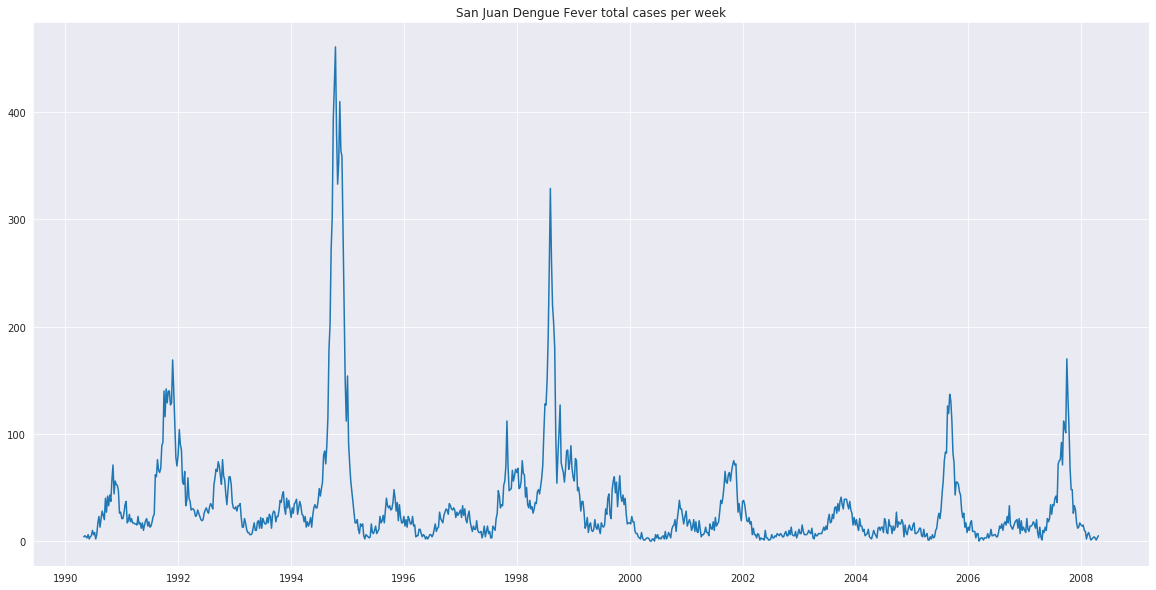

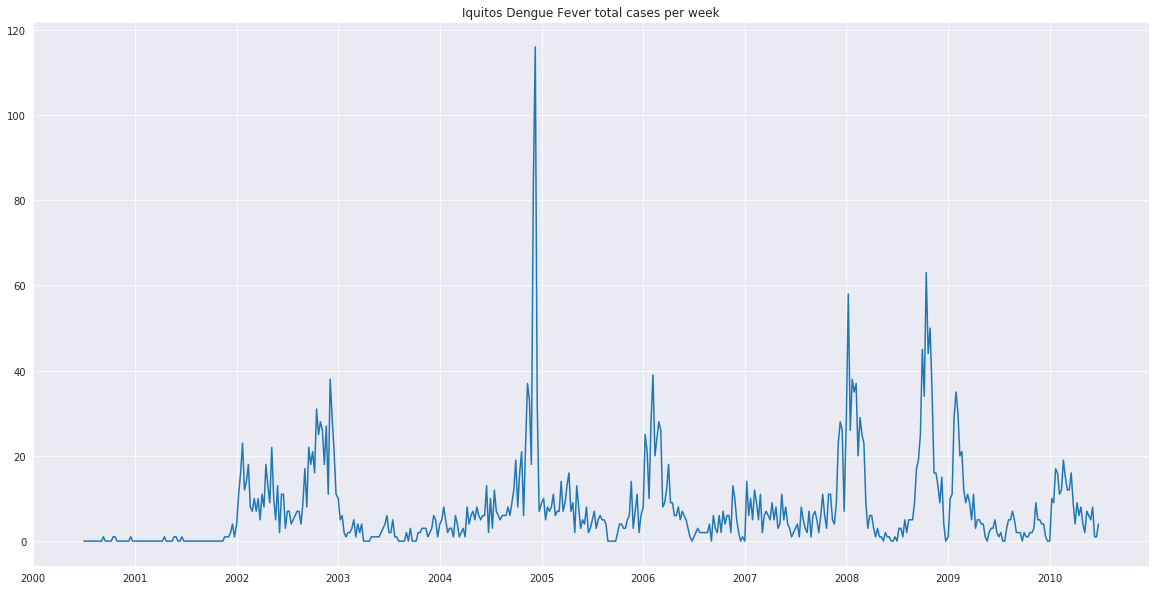

In [91]:
# look at the history of cases in San Juan again
x = sj_combined['week_start_date']
y = sj_combined['total_cases']
plt.figure(figsize=(20,10))
plt.plot(x,y)
plt.title('San Juan Dengue Fever total cases per week')
plt.show()

# look at the history of cases in San Juan again
x = iq_combined['week_start_date']
y = iq_combined['total_cases']
plt.figure(figsize=(20,10))
plt.plot(x,y)
plt.title('Iquitos Dengue Fever total cases per week')
plt.show()



# normalize the data - TBD

# model training and predictions with only the drivendata data

In [93]:
sj_combined.drop(['year', 'weekofyear'], axis=1, inplace=True)

In [94]:
sj_combined.head()

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [96]:
sj_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 22 columns):
week_start_date                          936 non-null datetime64[ns]
ndvi_ne                                  936 non-null float64
ndvi_nw                                  936 non-null float64
ndvi_se                                  936 non-null float64
ndvi_sw                                  936 non-null float64
precipitation_amt_mm                     936 non-null float64
reanalysis_air_temp_k                    936 non-null float64
reanalysis_avg_temp_k                    936 non-null float64
reanalysis_dew_point_temp_k              936 non-null float64
reanalysis_max_air_temp_k                936 non-null float64
reanalysis_min_air_temp_k                936 non-null float64
reanalysis_precip_amt_kg_per_m2          936 non-null float64
reanalysis_relative_humidity_percent     936 non-null float64
reanalysis_sat_precip_amt_mm             936 non-null float64
reanalysis_specific_

In [97]:
sj_combined.columns

Index(['week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases'],
      dtype='object')

# format data for LSTM and try models on San Juan data

In [98]:
# modified from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 


In [99]:
# load dataset
# dataset = read_csv('pollution.csv', header=0, index_col=0)
dataset = sj_combined.copy()
# df[df.columns[2:4]]
values = dataset[dataset.columns[1:23]].values

# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 4, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[0]], axis=1, inplace=True)
print(reframed.head())

   var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  var7(t-4)  \
4   0.626763   0.523701   0.541889   0.031797   0.261009   0.269188   
5   0.669811   0.435300   0.492142   0.058423   0.362995   0.384892   
6   0.704284   0.422680   0.526662   0.088428   0.454029   0.456909   
7   0.785005   0.594845   0.672866   0.039324   0.486881   0.514759   
8   0.804187   0.652699   0.698613   0.019252   0.571758   0.586777   

   var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  ...  var12(t)  var13(t)  \
4   0.339931   0.307693    0.452057    0.056091  ...  0.658555  0.019252   
5   0.528473   0.476925    0.520550    0.031446  ...  0.631272  0.024526   
6   0.710358   0.415386    0.643837    0.045749  ...  0.732451  0.008909   
7   0.695110   0.553848    0.602741    0.024365  ...  0.798465  0.386892   
8   0.757843   0.630772    0.671234    0.021385  ...  0.769331  0.049462   

   var14(t)  var15(t)  var16(t)  var17(t)  var18(t)  var19(t)  var20(t)  \
4  0.711300  0.539535  0.843874  0.899204

In [100]:
reframed.shape

(932, 104)

In [101]:
len(values)

936

In [102]:
# split into train and test sets
values = reframed.values

# n_train_hours = 365 * 24
n_train_weeks = math.floor(len(values) * .7)
# n_test_week = len(values) - n_train_weeks

train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(652, 1, 103) (652,) (280, 1, 103) (280,)


In [168]:
# values

Train on 652 samples, validate on 280 samples
Epoch 1/100
 - 0s - loss: 0.0767 - val_loss: 0.0302
Epoch 2/100
 - 0s - loss: 0.0684 - val_loss: 0.0358
Epoch 3/100
 - 0s - loss: 0.0601 - val_loss: 0.0295
Epoch 4/100
 - 0s - loss: 0.0608 - val_loss: 0.0288
Epoch 5/100
 - 0s - loss: 0.0604 - val_loss: 0.0301
Epoch 6/100
 - 0s - loss: 0.0583 - val_loss: 0.0278
Epoch 7/100
 - 0s - loss: 0.0577 - val_loss: 0.0299
Epoch 8/100
 - 0s - loss: 0.0548 - val_loss: 0.0278
Epoch 9/100
 - 0s - loss: 0.0546 - val_loss: 0.0272
Epoch 10/100
 - 0s - loss: 0.0523 - val_loss: 0.0254
Epoch 11/100
 - 0s - loss: 0.0440 - val_loss: 0.0247
Epoch 12/100
 - 0s - loss: 0.0405 - val_loss: 0.0242
Epoch 13/100
 - 0s - loss: 0.0369 - val_loss: 0.0220
Epoch 14/100
 - 0s - loss: 0.0361 - val_loss: 0.0266
Epoch 15/100
 - 0s - loss: 0.0358 - val_loss: 0.0245
Epoch 16/100
 - 0s - loss: 0.0354 - val_loss: 0.0237
Epoch 17/100
 - 0s - loss: 0.0340 - val_loss: 0.0279
Epoch 18/100
 - 0s - loss: 0.0346 - val_loss: 0.0184
Epoch 19/

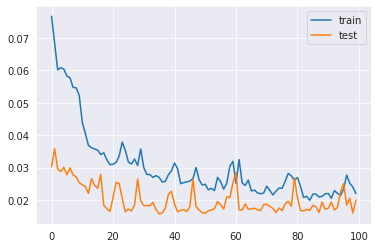

In [112]:
# design network
model = Sequential()
model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))


# test adding a dropout layer
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))


model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 652 samples, validate on 280 samples
Epoch 1/190
 - 0s - loss: 0.1209 - val_loss: 0.0905
Epoch 2/190
 - 0s - loss: 0.1024 - val_loss: 0.0317
Epoch 3/190
 - 0s - loss: 0.0863 - val_loss: 0.0640
Epoch 4/190
 - 0s - loss: 0.0536 - val_loss: 0.0293
Epoch 5/190
 - 0s - loss: 0.0472 - val_loss: 0.0348
Epoch 6/190
 - 0s - loss: 0.0527 - val_loss: 0.0298
Epoch 7/190
 - 0s - loss: 0.0502 - val_loss: 0.0268
Epoch 8/190
 - 0s - loss: 0.0472 - val_loss: 0.0276
Epoch 9/190
 - 0s - loss: 0.0482 - val_loss: 0.0345
Epoch 10/190
 - 0s - loss: 0.0488 - val_loss: 0.0450
Epoch 11/190
 - 0s - loss: 0.0597 - val_loss: 0.0576
Epoch 12/190
 - 0s - loss: 0.0781 - val_loss: 0.0553
Epoch 13/190
 - 0s - loss: 0.0426 - val_loss: 0.0263
Epoch 14/190
 - 0s - loss: 0.0352 - val_loss: 0.0244
Epoch 15/190
 - 0s - loss: 0.0367 - val_loss: 0.0264
Epoch 16/190
 - 0s - loss: 0.0373 - val_loss: 0.0210
Epoch 17/190
 - 0s - loss: 0.0342 - val_loss: 0.0210
Epoch 18/190
 - 0s - loss: 0.0374 - val_loss: 0.0219
Epoch 19/

Epoch 154/190
 - 0s - loss: 0.0211 - val_loss: 0.0147
Epoch 155/190
 - 0s - loss: 0.0204 - val_loss: 0.0163
Epoch 156/190
 - 0s - loss: 0.0227 - val_loss: 0.0164
Epoch 157/190
 - 0s - loss: 0.0220 - val_loss: 0.0169
Epoch 158/190
 - 0s - loss: 0.0235 - val_loss: 0.0162
Epoch 159/190
 - 0s - loss: 0.0238 - val_loss: 0.0218
Epoch 160/190
 - 0s - loss: 0.0325 - val_loss: 0.0211
Epoch 161/190
 - 0s - loss: 0.0221 - val_loss: 0.0145
Epoch 162/190
 - 0s - loss: 0.0206 - val_loss: 0.0151
Epoch 163/190
 - 0s - loss: 0.0203 - val_loss: 0.0155
Epoch 164/190
 - 0s - loss: 0.0214 - val_loss: 0.0177
Epoch 165/190
 - 0s - loss: 0.0235 - val_loss: 0.0155
Epoch 166/190
 - 0s - loss: 0.0231 - val_loss: 0.0176
Epoch 167/190
 - 0s - loss: 0.0247 - val_loss: 0.0196
Epoch 168/190
 - 0s - loss: 0.0318 - val_loss: 0.0203
Epoch 169/190
 - 0s - loss: 0.0217 - val_loss: 0.0144
Epoch 170/190
 - 0s - loss: 0.0205 - val_loss: 0.0157
Epoch 171/190
 - 0s - loss: 0.0204 - val_loss: 0.0152
Epoch 172/190
 - 0s - loss: 

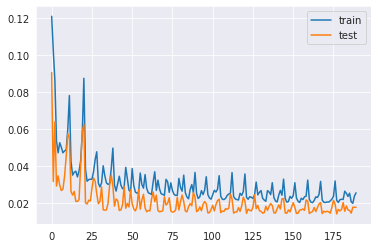

In [140]:
# design network
model = Sequential()
model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=190, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 652 samples, validate on 280 samples
Epoch 1/50
 - 0s - loss: 0.0858 - val_loss: 0.0409
Epoch 2/50
 - 0s - loss: 0.0674 - val_loss: 0.0410
Epoch 3/50
 - 0s - loss: 0.0649 - val_loss: 0.0442
Epoch 4/50
 - 0s - loss: 0.0666 - val_loss: 0.0317
Epoch 5/50
 - 0s - loss: 0.0640 - val_loss: 0.0373
Epoch 6/50
 - 0s - loss: 0.0542 - val_loss: 0.0326
Epoch 7/50
 - 0s - loss: 0.0502 - val_loss: 0.0341
Epoch 8/50
 - 0s - loss: 0.0494 - val_loss: 0.0437
Epoch 9/50
 - 0s - loss: 0.0558 - val_loss: 0.0561
Epoch 10/50
 - 0s - loss: 0.0668 - val_loss: 0.0281
Epoch 11/50
 - 0s - loss: 0.0427 - val_loss: 0.0252
Epoch 12/50
 - 0s - loss: 0.0383 - val_loss: 0.0250
Epoch 13/50
 - 0s - loss: 0.0379 - val_loss: 0.0366
Epoch 14/50
 - 0s - loss: 0.0445 - val_loss: 0.0455
Epoch 15/50
 - 0s - loss: 0.0564 - val_loss: 0.0195
Epoch 16/50
 - 0s - loss: 0.0448 - val_loss: 0.0221
Epoch 17/50
 - 0s - loss: 0.0385 - val_loss: 0.0225
Epoch 18/50
 - 0s - loss: 0.0382 - val_loss: 0.0288
Epoch 19/50
 - 0s - loss: 0

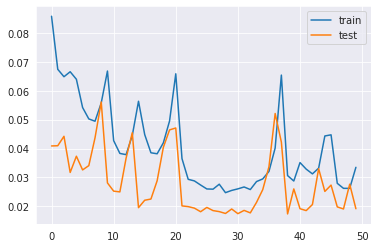

In [141]:
# design network
model = Sequential()
model.add(LSTM(85, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# format data for LSTM and try models on Iquitos data

In [142]:
df_iq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 23 columns):
week_start_date                          520 non-null datetime64[ns]
year                                     520 non-null int64
weekofyear                               520 non-null int64
ndvi_ne                                  520 non-null float64
ndvi_nw                                  520 non-null float64
ndvi_se                                  520 non-null float64
ndvi_sw                                  520 non-null float64
precipitation_amt_mm                     520 non-null float64
reanalysis_air_temp_k                    520 non-null float64
reanalysis_avg_temp_k                    520 non-null float64
reanalysis_dew_point_temp_k              520 non-null float64
reanalysis_max_air_temp_k                520 non-null float64
reanalysis_min_air_temp_k                520 non-null float64
reanalysis_precip_amt_kg_per_m2          520 non-null float64
reanalysis_relative_humi

In [113]:
# load dataset
# dataset = read_csv('pollution.csv', header=0, index_col=0)
dataset = iq_combined.copy()
# df[df.columns[2:4]]
values = dataset[dataset.columns[1:24]].values

# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 4, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[0]], axis=1, inplace=True)
print(reframed.head())

   var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  var7(t-4)  \
4   0.480769   0.293660   0.230302   0.611693   0.379834   0.120524   
5   0.500000   0.347279   0.573956   0.510542   0.368330   0.287483   
6   0.519231   0.257549   0.327948   0.342688   0.132475   0.263340   
7   0.538462   0.371674   0.261770   0.441198   0.282527   0.026562   
8   0.557692   0.597620   0.683923   0.441535   0.616104   0.297681   

   var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  ...  var14(t)  var15(t)  \
4   0.300549   0.442669    0.609428    0.521429  ...  0.744051  0.297681   
5   0.285450   0.439999    0.630276    0.471430  ...  0.414999  0.077029   
6   0.254234   0.311111    0.661880    0.321430  ...  0.624370  0.423896   
7   0.103043   0.166222    0.323936    0.257145  ...  0.605123  0.199592   
8   0.256683   0.341331    0.462669    0.500000  ...  0.415279  0.233458   

   var16(t)  var17(t)  var18(t)  var19(t)  var20(t)  var21(t)  var22(t)  \
4  0.399145  0.469838  0.553191  0.592453

In [114]:
reframed.shape

(516, 114)

In [115]:
len(values)

520

In [116]:
# split into train and test sets
values = reframed.values

# n_train_hours = 365 * 24
n_train_weeks = math.floor(len(values) * .8)
# n_test_week = len(values) - n_train_weeks

train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(412, 1, 113) (412,) (104, 1, 113) (104,)


Train on 412 samples, validate on 104 samples
Epoch 1/100
 - 0s - loss: 0.0935 - val_loss: 0.0691
Epoch 2/100
 - 0s - loss: 0.0785 - val_loss: 0.0662
Epoch 3/100
 - 0s - loss: 0.0702 - val_loss: 0.0617
Epoch 4/100
 - 0s - loss: 0.0628 - val_loss: 0.0605
Epoch 5/100
 - 0s - loss: 0.0570 - val_loss: 0.0578
Epoch 6/100
 - 0s - loss: 0.0540 - val_loss: 0.0583
Epoch 7/100
 - 0s - loss: 0.0500 - val_loss: 0.0566
Epoch 8/100
 - 0s - loss: 0.0476 - val_loss: 0.0577
Epoch 9/100
 - 0s - loss: 0.0452 - val_loss: 0.0534
Epoch 10/100
 - 0s - loss: 0.0432 - val_loss: 0.0576
Epoch 11/100
 - 0s - loss: 0.0422 - val_loss: 0.0503
Epoch 12/100
 - 0s - loss: 0.0410 - val_loss: 0.0559
Epoch 13/100
 - 0s - loss: 0.0405 - val_loss: 0.0501
Epoch 14/100
 - 0s - loss: 0.0391 - val_loss: 0.0484
Epoch 15/100
 - 0s - loss: 0.0386 - val_loss: 0.0522
Epoch 16/100
 - 0s - loss: 0.0384 - val_loss: 0.0509
Epoch 17/100
 - 0s - loss: 0.0373 - val_loss: 0.0511
Epoch 18/100
 - 0s - loss: 0.0364 - val_loss: 0.0463
Epoch 19/

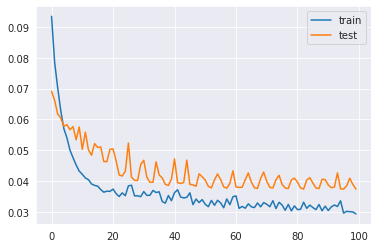

In [120]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))

# test adding a dropout layer
# model.add(Dropout(0.3))
# model.add(Dense(50))  # this dramatically (>50%) improved the val_loss

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

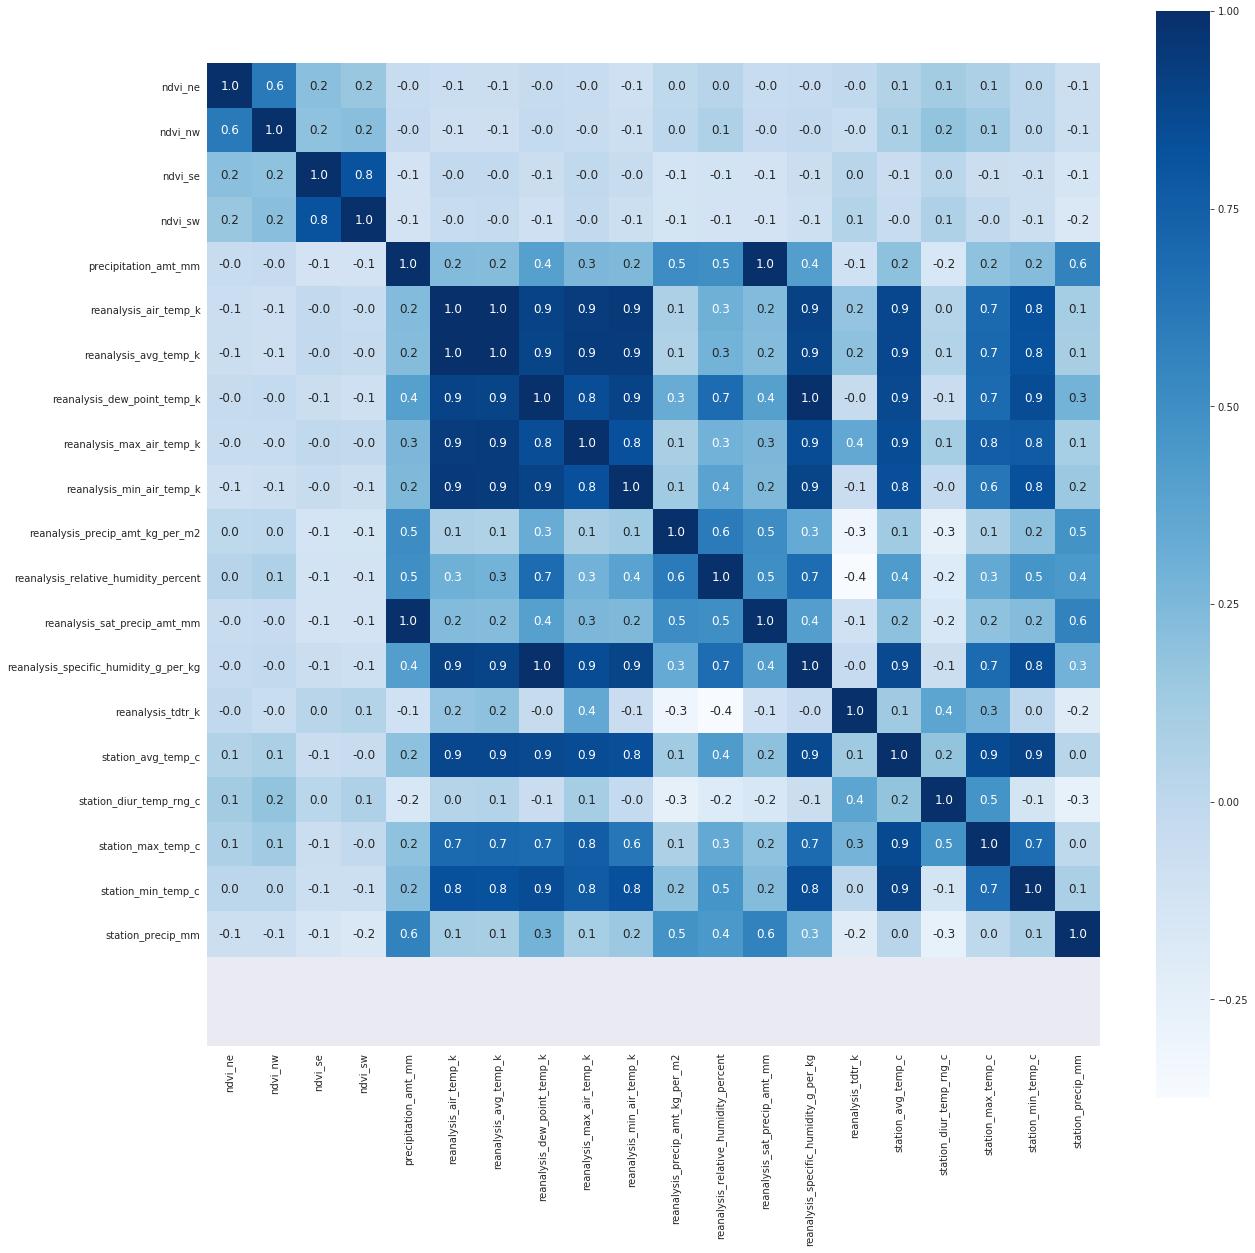

In [121]:
# look at a correlation heat map for San Juan

# df_corr = df_sj.drop('total_cases', axis=1)
# f,ax = plt.subplots(figsize=(20,20))
# sns.heatmap(df_corr.loc[:,:].corr(), annot=True, cmap="Blues", fmt='.1f' )

# hm.set_ylim(10,0)
# plt.show()


df_corr = sj_combined.drop('total_cases', axis=1)
f,ax = plt.subplots(figsize=(20,20))
hm = sns.heatmap(df_corr.loc[:,:].corr(), annot=True, square=True, cmap="Blues", fmt='.1f', annot_kws={'size': 12} )
sns.set(font_scale=1.3)
hm.set_ylim(22,0)
plt.show()



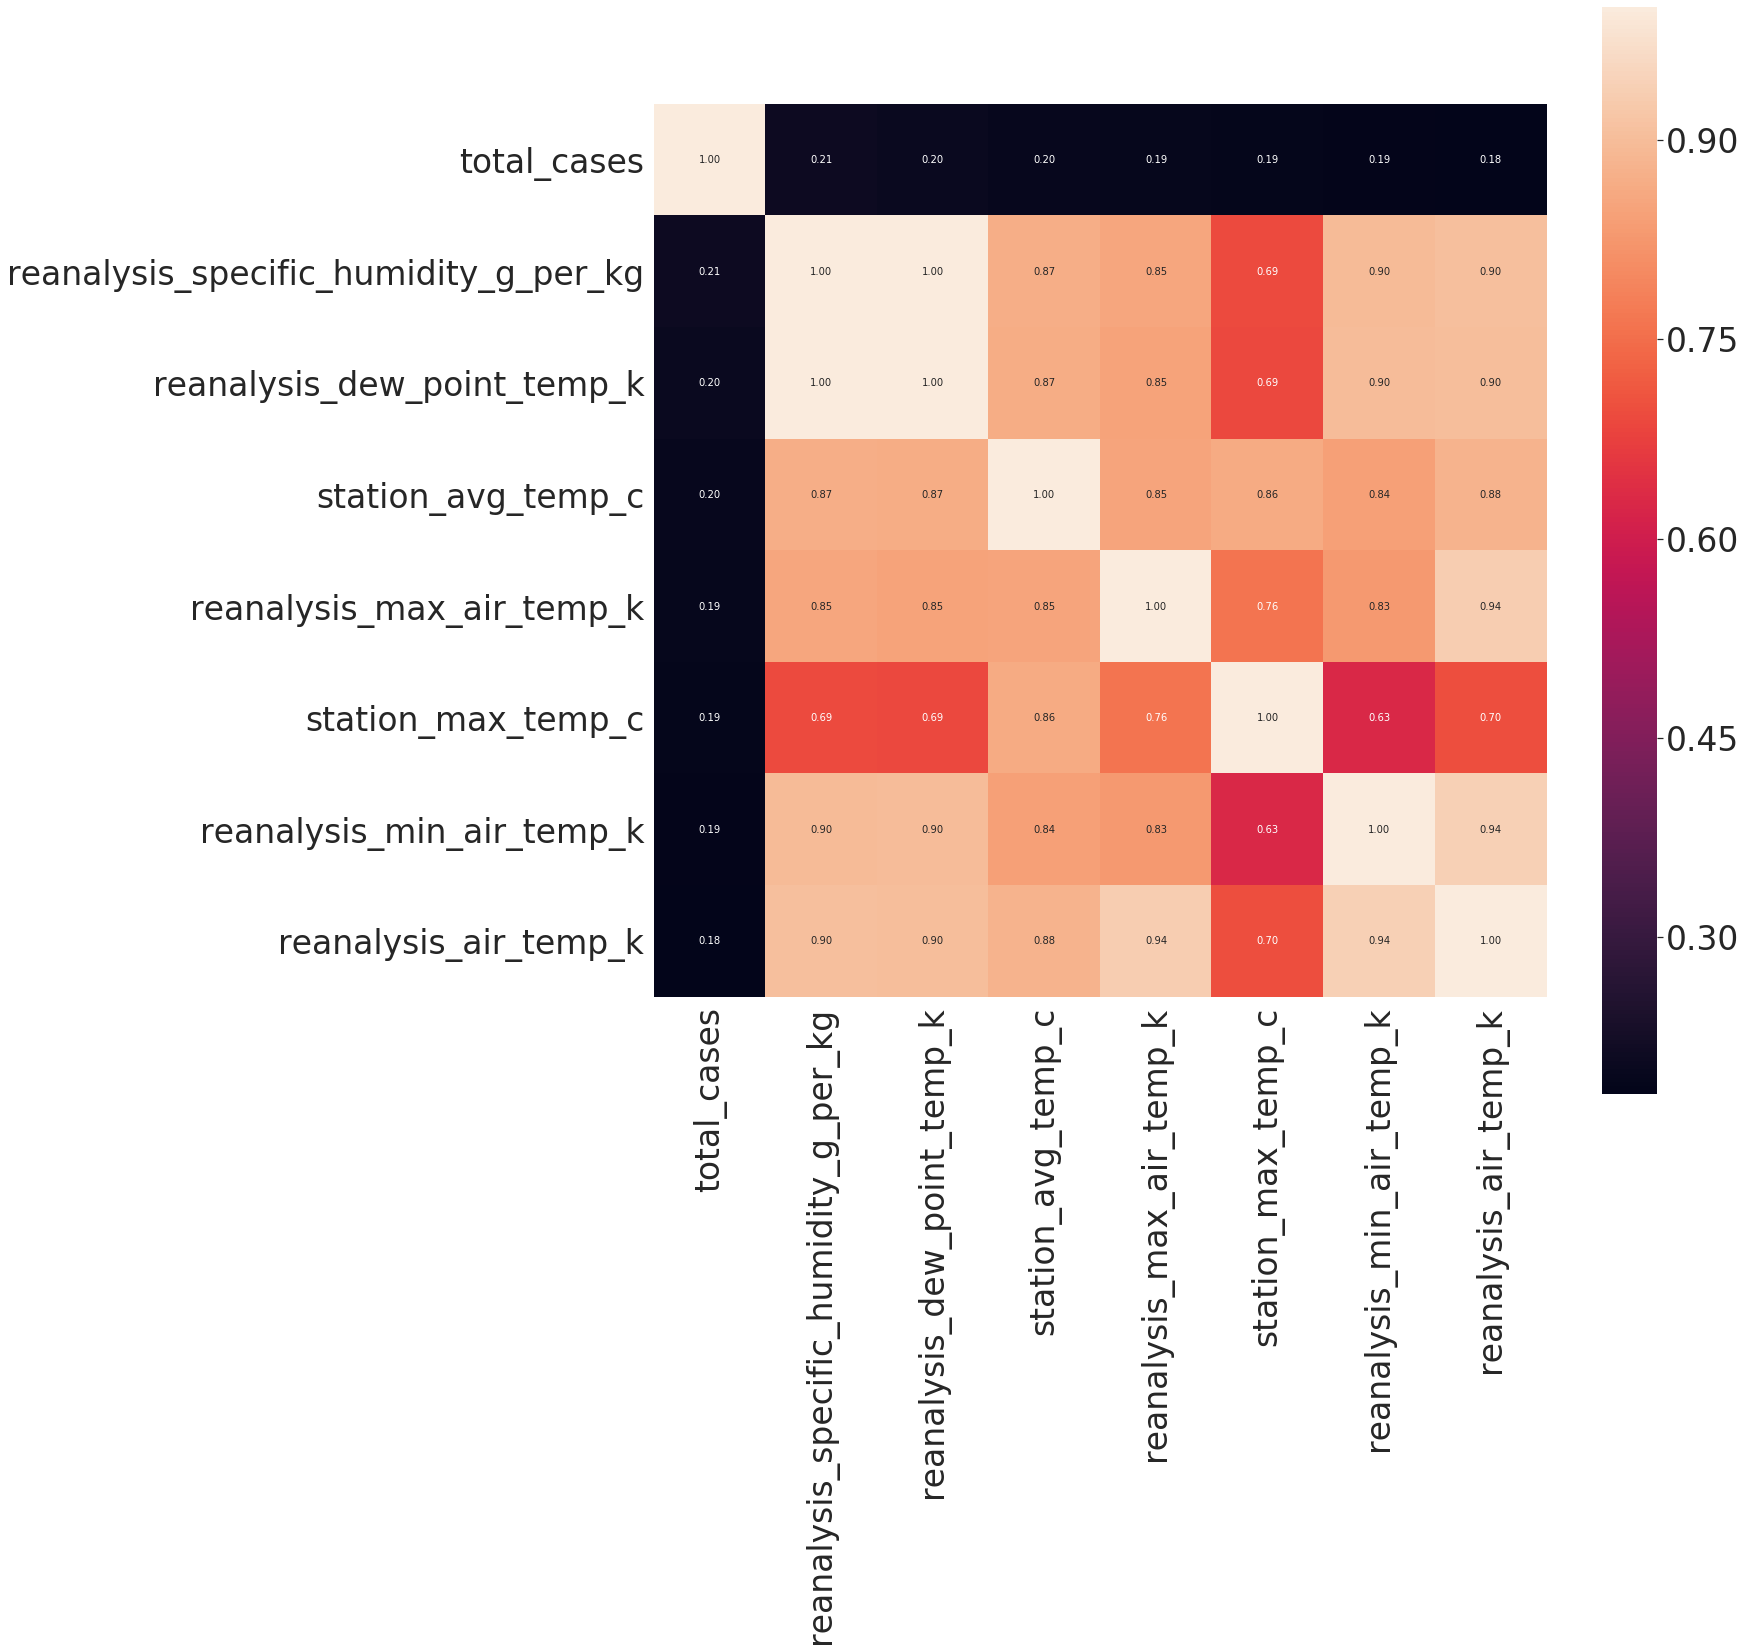

In [123]:
corrmat = sj_combined.corr()
k = 8 #number of variables for heatmap
cols = corrmat.nlargest(k, 'total_cases')['total_cases'].index
cm = np.corrcoef(sj_combined[cols].values.T)

plt.figure(figsize=(20,20))

sns.set(font_scale=3)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels = cols.values, xticklabels = cols.values)

# plt.tight_layout()
# hm.get_ylim()
# print(hm.get_ylim())
hm.set_ylim(8,0)
plt.show()

In [735]:
train = df_sj[:int(0.8*(len(df_sj)))]
valid = df_sj[int(0.8*(len(df_sj))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train, exog= )
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))



In [736]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 748 entries, 0 to 747
Data columns (total 23 columns):
week_start_date                          748 non-null datetime64[ns]
year                                     748 non-null int64
weekofyear                               748 non-null int64
ndvi_ne                                  748 non-null float64
ndvi_nw                                  748 non-null float64
ndvi_se                                  748 non-null float64
ndvi_sw                                  748 non-null float64
precipitation_amt_mm                     748 non-null float64
reanalysis_air_temp_k                    748 non-null float64
reanalysis_avg_temp_k                    748 non-null float64
reanalysis_dew_point_temp_k              748 non-null float64
reanalysis_max_air_temp_k                748 non-null float64
reanalysis_min_air_temp_k                748 non-null float64
reanalysis_precip_amt_kg_per_m2          748 non-null float64
reanalysis_relative_humi

In [737]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 748 to 935
Data columns (total 23 columns):
week_start_date                          188 non-null datetime64[ns]
year                                     188 non-null int64
weekofyear                               188 non-null int64
ndvi_ne                                  188 non-null float64
ndvi_nw                                  188 non-null float64
ndvi_se                                  188 non-null float64
ndvi_sw                                  188 non-null float64
precipitation_amt_mm                     188 non-null float64
reanalysis_air_temp_k                    188 non-null float64
reanalysis_avg_temp_k                    188 non-null float64
reanalysis_dew_point_temp_k              188 non-null float64
reanalysis_max_air_temp_k                188 non-null float64
reanalysis_min_air_temp_k                188 non-null float64
reanalysis_precip_amt_kg_per_m2          188 non-null float64
reanalysis_relative_hu

In [ ]:
# save this example of the json object returned by the darksky api

# {
#     "latitude": 18.4653,
#     "longitude": -66.1167,
#     "timezone": "America/Puerto_Rico",
#     "daily": {
#         "data": [
#             {
#                 "time": 609998400,
#                 "summary": "Drizzle in the morning.",
#                 "icon": "rain",
#                 "sunriseTime": 610019894,
#                 "sunsetTime": 610066033,
#                 "moonPhase": 0.87,
#                 "precipIntensity": 0.001,
#                 "precipIntensityMax": 0.0118,
#                 "precipIntensityMaxTime": 610005600,
#                 "precipProbability": 1,
#                 "precipType": "rain",
#                 "temperatureHigh": 85.9,
#                 "temperatureHighTime": 610048800,
#                 "temperatureLow": 72.95,
#                 "temperatureLowTime": 610095600,
#                 "apparentTemperatureHigh": 88.2,
#                 "apparentTemperatureHighTime": 610048800,
#                 "apparentTemperatureLow": 74.07,
#                 "apparentTemperatureLowTime": 610095600,
#                 "dewPoint": 70.15,
#                 "humidity": 0.77,
#                 "pressure": 1017,
#                 "windSpeed": 10.32,
#                 "windBearing": 110,
#                 "cloudCover": 0.41,
#                 "uvIndex": 6,
#                 "uvIndexTime": 610038000,
#                 "temperatureMin": 72.95,
#                 "temperatureMinTime": 610009200,
#                 "temperatureMax": 85.9,
#                 "temperatureMaxTime": 610048800,
#                 "apparentTemperatureMin": 74.36,
#                 "apparentTemperatureMinTime": 610009200,
#                 "apparentTemperatureMax": 88.2,
#                 "apparentTemperatureMaxTime": 610048800
#             }
#         ]
#     },
#     "offset": -4
# }